In [2]:
from keras.layers  import Dense, Dropout, Input, ReLU
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 2 tane tuple döndürecek.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 55s 5us/step


In [4]:
# Bir nevi Sıkıştırma işlemi (-1 ile 0 arasında)
x_train = (x_train.astype(np.float32)-127.5) / 127.5
x_train.shape

(60000, 28, 28)

In [5]:
# 60000, 28 * 28
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_train.shape

(60000, 784)

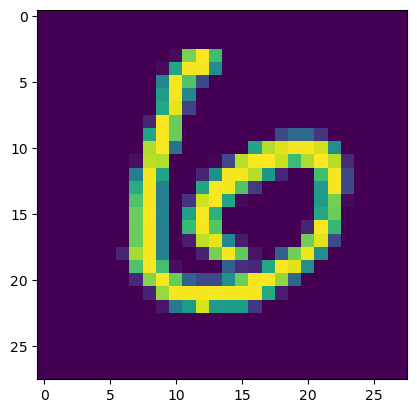

In [7]:
plt.imshow(x_test[11])

In [17]:
# Create Generator Model
# input -> Neural Network -> output
# input -> Dense Layer (512 unit) -ReLU-> Dense Layer (512 unit) -ReLU-> Dense Layer ( 1024) -> -ReLU-> Dense Layer (784) 
# -tanh-> output
def create_generator():
    # layerları üstüne ekleyeceğimiz sequential bir yapı oluşturuyoruz.
    generator = Sequential()
    generator.add(Dense(units = 512, input_dim = 100))
    generator.add(ReLU())
    
    generator.add(Dense(units = 512))
    generator.add(ReLU())
    
    generator.add(Dense(units = 1024))
    generator.add(ReLU())
    
    generator.add(Dense(units = 784, activation = "tanh"))
    
    # 2 tane outputumuz oldugundan binary cross entropy seçtik.
    generator.compile(loss = "binary_crossentropy",
                     optimizer = Adam(lr = 0.0001, beta_1 = 0.5))
    return generator

g = create_generator()
g.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 512)               51712     
                                                                 
 re_lu_9 (ReLU)              (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 re_lu_10 (ReLU)             (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 1024)              525312    
                                                                 
 re_lu_11 (ReLU)             (None, 1024)              0         
                                                                 
 dense_15 (Dense)            (None, 784)              

C:\Users\aleyy\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [18]:
# Create Discriminator Model
# input -> Dense Layer (1024 nöron) -ReLU + Dropout (0.4)-> Dense Layer (512 unit) -ReLU + Dropout-> Dense Layer (256) -ReLU-> 
# output layer (1 unit) -> sigmoid activation function -> output (fake or real)
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(units = 1024, input_dim = 784))
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))
    
    discriminator.add(Dense(units = 512))
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))
    
    discriminator.add(Dense(units = 256))
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))
    
    discriminator.add(Dense(units = 1, activation = "sigmoid"))
    
    discriminator.compile(loss = "binary_crossentropy",
                         optimizer = Adam(lr = 0.0001, beta_1 = 0.5))
    return discriminator

In [22]:
d = create_discriminator()
d.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 1024)              803840    
                                                                 
 re_lu_12 (ReLU)             (None, 1024)              0         
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_17 (Dense)            (None, 512)               524800    
                                                                 
 re_lu_13 (ReLU)             (None, 512)               0         
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 256)              

In [23]:
# GANs Modeli
# input -> generator - x -> discriminator -> output
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape = (100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs = gan_input, outputs = gan_output)
    gan.compile(loss = "binary_crossentropy",
                optimizer = "adam")
    return gan
    

In [24]:
gan = create_gan(d, g)
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_3 (Sequential)   (None, 784)               1643280   
                                                                 
 sequential_4 (Sequential)   (None, 1)                 1460225   
                                                                 
Total params: 3,103,505
Trainable params: 1,643,280
Non-trainable params: 1,460,225
_________________________________________________________________


In [25]:
# Gans train
epochs = 50
batch_size = 256

for e in range(epochs):
    for _ in range(batch_size):
        # discriminatorımızı eğitmek için bizim generated image'a ihtiyacımız var. Bu generated image'ı generator'ımızdan elde 
        # edeceğiz.
        # noise -> generator -> generated images--\
        #                                          ----> d
        # real_images (train datasetten gelecek)--/
        
        noise =np.random.normal(0, 1, [batch_size, 100])
        # neural network yapısına sahip olan generator'ımızın içerisine noise'ı soktuğumuz zaman bize generated image'ları 
        # return edecek.
        generated_images = g.predict(noise)
        
        # Şimdi gerçek imageleri x_train datasetinden rastgele seçerek alalım. 
        image_batch = x_train[np.random.randint(low = 0, high = x_train.shape[0], size = batch_size)]
        
        # gerçekleri ve fakeleri birleştiriyoruz.
        x = np.concatenate([image_batch, generated_images])
        
        # discriminatorı eğitmek için gerekli olan resimlerin labelına ihtiyacımız var.
        # Tam 512 tane 0 yaratacak bize.
        y_dis = np.zeros(batch_size * 2)
        
        # labellarımızı batch_size'a kadar (ilk 256'sını) olanlarını 1 olarak labellamak istiyoruz. Çünkü ilk 256 tanesi gerçek 
        # resim, sonrası da fake resimlerden oluşuyor.
        y_dis[:batch_size] = 1
        
        # discriminatorımızı eğitmeye başlayalım.
        d.trainable = True
        d.train_on_batch(x, y_dis)
        
        # generator modelimizi eğitelim.
        noise = np.random.normal(0, 1, [batch_size, 100])
        
        # tekrar labellama işlemi yapıyoruz.
        y_gen = np.ones(batch_size)
        
        d.trainable = False
        
        gan.train_on_batch(noise, y_gen)
        
    print("epochs : ", e)

8/8 [==============================] - 0s 5ms/step
epochs :  0
8/8 [==============================] - 0s 3ms/step
epochs :  1
8/8 [==============================] - 0s 4ms/step
epochs :  2
8/8 [==============================] - 0s 6ms/step
epochs :  3
8/8 [==============================] - 0s 5ms/step
epochs :  4
8/8 [==============================] - 0s 5ms/step
epochs :  5
8/8 [==============================] - 0s 4ms/step
epochs :  6
8/8 [==============================] - 0s 5ms/step
epochs :  7
8/8 [==============================] - 0s 5ms/step
epochs :  8
8/8 [==============================] - 0s 5ms/step
epochs :  9
8/8 [==============================] - 0s 7ms/step
epochs :  10
8/8 [==============================] - 0s 3ms/step
epochs :  11
8/8 [==============================] - 0s 7ms/step
epochs :  12
8/8 [==============================] - 0s 5ms/step
epochs :  13
8/8 [==============================] - 0s 7ms/step
epochs :  14
8/8 [==============================] - 0s 5ms/step

4/4 [==============================] - 0s 23ms/step


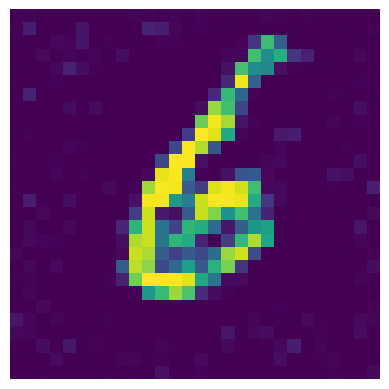

In [28]:
# GANs Sonuçlar

# modeli kaydetme
g.save_weights('gans_model.h5')

# görselleştirme:

# bir tane noise oluşturduk.
noise =np.random.normal(loc = 0, scale = 1, size = [100, 100])

# noise'u generatorımızda predict ediyoruz.
generated_images = g.predict(noise)

# daha sonra görselleştirme yapıyoruz.
generated_images = generated_images.reshape(100, 28, 28)
plt.imshow(generated_images[66], interpolation = 'nearest')
plt.axis('off')
plt.show()

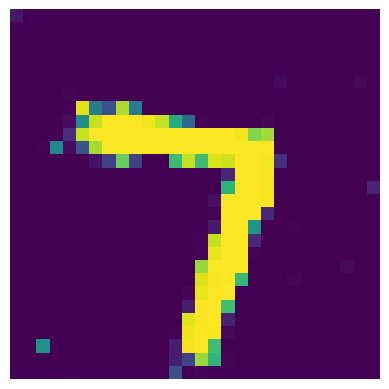

In [29]:
plt.imshow(generated_images[55], interpolation = 'nearest')
plt.axis('off')
plt.show()

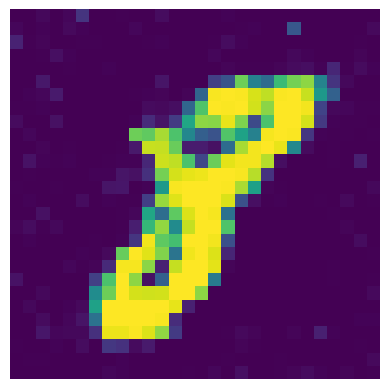

In [34]:
plt.imshow(generated_images[11], interpolation = 'nearest')
plt.axis('off')
plt.show()